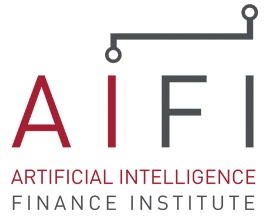


# Bootcamp - Python and Coding - Deep Learning

## Open notebook in:
| Colab                                 |  Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH07/ch07_DPO.ipynb)                                              | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH07/ch07_DPO.ipynb)|             

In [ ]:
# Clone repo, if it's not already cloned, to be sure all runs smoothly
# on Colab, Kaggle or Paperspace
import os

if not os.path.isdir('Transformers-in-Action'):
    !git clone https://github.com/Nicolepcx/Transformers-in-Action.git
else:
    print('Repository already exists. Skipping clone.')


current_path = %pwd
if '/Transformers-in-Action' in current_path:
    new_path = current_path + '/utils'
else:
    new_path = current_path + '/Transformers-in-Action/utils'
%cd $new_path


Cloning into 'Transformers-in-Action'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 2.45 MiB | 6.52 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/Transformers-in-Action/utils


# About this notebook



RLHF, a method used for refining the responses of chatbot systems like ChatGPT, Alpaca, and StableVicuna. However, RLHF is a complex method that requires a reward model reflecting human preferences as a foundational element. This model can be developed specifically for the task at hand or used from a pre-trained version created by others. The next step involves fine-tuning the LLM using RL to maximize the policy based on this reward model. 

Direct preference optimization (DPO) offers a streamlined alternative by directly optimizing the LLM's policy by passing the need for an explicit reward model. DPO and RLHF share the same ultimate objective to align the LLM's outputs with human preferences. However, DPO simplifies the approach by directly incorporating human preferences into the optimization process without first modeling them as a separate reward function.

The essence of DPO lies in its method of directly adjusting the language model's parameters to favor preferred responses over less desired ones, based on direct feedback. This is achieved through a constraint optimization process, where the Kullback-Leibler (KL) divergence plays a crucial role. The KL divergence measures the difference between the probability distribution of the LLM's responses and a target distribution that represents human preferences. By minimizing this divergence, DPO ensures the model's outputs are closely aligned with what is preferred, effectively making the optimization task resemble a classification problem where each response is classified as preferred or not. he process involves:

- Supervised  ne-tuning step (same as for RLHF)
- Annotating data with preference labels (same as for RLHF) 
- DPO-Step

Thus, DPO directly optimizes the language model on preference data (preferred prompts), streamlining the process by eliminating the intermediate step of reward modeling required in RLHF. The graphical comparison in the figure below illustrates how DPO simplifies the alignment of LLMs with human preferences by directly incorporating preference feedback into the optimization process.

In this notebook we will do the SFT-step, and in notebook `15_DPO_LLM.ipynb`, the DPO-step. 

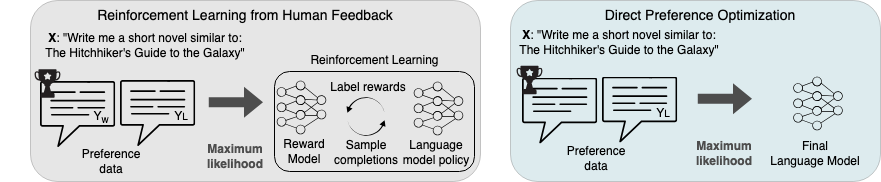

#Install requirements

In [ ]:
from requirements import *

In [ ]:
!pip install wandb transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


# Install unsloth

In [ ]:
%%capture
import torch

# Function to determine the appropriate Unsloth installation based on CUDA major version
def install_unsloth():
    major_version = torch.cuda.get_device_capability()[0]  # Get the major version
    if major_version >= 8:
        # For new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
        !pip install "unsloth[colab_ampere] @ git+https://github.com/unslothai/unsloth.git"
    else:
        # For older GPUs (V100, Tesla T4, RTX 20xx)
        !pip install "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"

# Install Unsloth based on the GPU's CUDA major version
install_unsloth()


# Imports

In [ ]:
from peft import PeftModel
from unsloth import FastLanguageModel
import wandb
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset
import textwrap

/usr/local/lib/python3.10/dist-packages/unsloth/__init__.py:67: UserWarning: Running `ldconfig /usr/lib64-nvidia` to link CUDA.
  warnings.warn(


In [ ]:
model, model_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit",
    max_seq_length = 4096,
    dtype = None, # Auto dectect type
    load_in_4bit = True # Use 4bit quantization to reduce memory usage.
)

Unsloth: Your transformers version of 4.35.2 does not support native 4bit loading.
The minimum required version is 4.37.
Try `pip install "git+https://github.com/huggingface/transformers.git"`
to obtain the latest transformers build, then restart this session.
For now, we shall load `unsloth/mistral-7b` instead (still 4bit, just slower downloading).
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.1
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB
O^O/ \_/ \    CUDA capability = 7.5. Xformers = 0.0.22.post7. FA = False.
\        /    Pytorch version: 2.1.0+cu121. CUDA Toolkit = 12.1
 "-____-"     bfloat16 = FALSE. Platform = Linux



model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 42,
    max_seq_length = 4096,
)

Unsloth 2024.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

In [ ]:
#@title Alpaca dataset preparation code
alpaca_template = """Write a response that completes the task from below, following the instruction.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

def prepare_prompts(data):
    texts = [alpaca_template.format(inst, inp, out) for inst, inp, out in zip(data["instruction"], data["input"], data["output"])]
    return {"text": texts}


# Loading and formatting the dataset
alpaca_dataset = load_dataset("yahma/alpaca-cleaned", split="train")
formatted_dataset = alpaca_dataset.map(prepare_prompts, batched=True)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
training_args = TrainingArguments(
                per_device_train_batch_size = 2,
                gradient_accumulation_steps = 4,
                warmup_steps = 5,
                max_steps = 60,
                learning_rate = 2e-4,
                fp16 = not torch.cuda.is_bf16_supported(),
                bf16 = torch.cuda.is_bf16_supported(),
                logging_steps = 1,
                report_to = "wandb",
                optim = "adamw_8bit",
                weight_decay = 0.01,
                lr_scheduler_type = "cosine",
                seed = 42,
                output_dir = "outputs"
)

trainer = SFTTrainer(
    model = model,
    train_dataset = formatted_dataset,
    dataset_text_field = "text",
    max_seq_length = 4096,
    args = training_args
)

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

wandb: Currently logged in as: nicolepcx. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Unsloth: `use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`


Step,Training Loss
1,1.572200
2,1.358100
3,1.255900
4,1.260700
5,1.138600
6,1.060600
7,1.089000
8,1.171600
9,0.810000
10,0.974600


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# Prepare the prompt
prompt = model_tokenizer(
    [
        alpaca_template.format(
            "What is the iconic symbol of freedom at the US east coast?",  # instruction
            "",  # input
            "",  # output
        )
    ] * 1, return_tensors="pt").to("cuda")

# Model's generation settings
generation_parameters = {
    "max_new_tokens": 256,  # Maximum number of new tokens to generate
    "use_cache": True  # Whether to use past key values for attention
}

# Generate outputs using the model and the specified generation parameters
outputs = model.generate(**prompt, **generation_parameters)

# Decode the generated outputs
decoded_outputs = model_tokenizer.batch_decode(outputs, skip_special_tokens=True)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [ ]:
# Define the maximum line width (number of characters per line)
max_line_width = 80

# Cleaning and formatting the output
cleaned_outputs = []
for output in decoded_outputs:
    # Splitting the text into sections based on '\n'
    sections = output.split('\n')

    # Find the index where the actual content starts (skipping the first line)
    start_idx = 1 if len(sections) > 1 and sections[0].startswith("Write a response") else 0

    # Rejoin the relevant sections
    relevant_content = "\n".join(sections[start_idx:])

    # Remove unwanted characters and replace '###' with '\n'
    relevant_content = relevant_content.replace("###", "\n").replace("[", "").replace("]", "").replace("'", "")

    # Split the text into sections based on '\n'
    sections = relevant_content.split('\n')

    # Wrap text for each section and join them back with double newlines
    wrapped_sections = [textwrap.fill(section, width=max_line_width) for section in sections]
    formatted_output = '\n'.join(wrapped_sections)

    # Add the cleaned and formatted text to the list
    cleaned_outputs.append(formatted_output)

# Print the cleaned and formatted output
for text in cleaned_outputs:
    print(text)



 Instruction:
What is the iconic symbol of freedom at the US east coast?


 Input:



 Response:
The Statue of Liberty is the iconic symbol of freedom at the US east coast.
Located on Liberty Island in New York Harbor, the statue was a gift from France
to the United States in 1886 to celebrate the centennial of American
independence. The statue is a symbol of freedom, and it represents the ideals of
liberty, equality, and opportunity. It has become an iconic symbol of the United
States and is visited by millions of tourists each year. The statue is also a
symbol of the United States role as a beacon of freedom and democracy in the
world.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

In [ ]:
model.save_pretrained("lora_sft_model") # Local saving
# model.push_to_hub("your_name/lora_sft_model") # Saving in Hugging Face